In [140]:
import uproot
import numpy as np
import awkward as ak

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

import pandas as pd

mpl.rc('image', cmap='Purples')
plt.style.use(hep.style.CMS)

In [141]:
from scipy.stats import norm

gauss_pdf = lambda x, mu, k, s: k * norm.pdf(x, mu, s)
gauss2_pdf = lambda x, m1, k1, s1, m2, k2, s2: gauss_pdf(x, m1, k1, s1) + gauss_pdf(x, m2, k2, s2)

In [142]:
f = uproot.open("/mnt/data/integration/me0stack/tracks/00000040.root")
f.keys()

['trackTree;6', 'trackTree;5']

In [143]:
t = f["trackTree"]
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
orbitNumber          | int32_t                  | AsDtype('>i4')
bunchCounter         | int32_t                  | AsDtype('>i4')
eventCounter         | int32_t                  | AsDtype('>i4')
rechitDigiStrip      | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitRawChannel     | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitChamber        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitEta            | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalX         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalY         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitR              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitPhi            | std::vector<double>      | AsJagged(AsDtype('>f8'), h

In [144]:
events = t.arrays(
    [
        "rechitChamber", "rechitEta",
        "rechitLocalX", "rechitLocalY", "rechitClusterSize",
        "rechitR", "rechitPhi",
        "partialTrackChamber", "partialTrackChi2",
        "partialProphitGlobalX", "partialProphitGlobalY",
        "partialProphitEta"
    ]#, entry_stop=2000000
)

In [145]:
rechits_chamber = events["rechitChamber"]
rechits_eta = events["rechitEta"]
rechits_cluster_size = events["rechitClusterSize"]
rechits_x = events["rechitLocalX"]
rechits_y = events["rechitLocalY"]
rechits_r = events["rechitR"]
rechits_phi = events["rechitPhi"]

print(rechits_chamber, ak.count(rechits_chamber, axis=1))
print(rechits_x, ak.count(rechits_x, axis=1))
print(rechits_y, ak.count(rechits_y, axis=1))

[[0, 1, 2], [0, 1, 2], [0, 1, 2], [], ..., [0, 1, 2], [0, 1, 2], [0, 1, 2]] [3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, ..., 3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3]
[[-34.7, -30.7, -25.3], [101, 90.4, 79], ..., [-92.4, ...], [-85.4, -76.5, -66]] [3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, ..., 3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3]
[[246, 246, 246], [345, 345, 345], [...], ..., [246, 246, 246], [345, 345, 345]] [3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 0, ..., 3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3]


In [146]:
prophits_chamber = events["partialTrackChamber"]
prophits_chi2 = events["partialTrackChi2"]
prophits_x = events["partialProphitGlobalX"]
prophits_y = events["partialProphitGlobalY"]

print(prophits_chamber, ak.count(prophits_chamber, axis=1))
print(prophits_x, ak.count(prophits_x, axis=1))
print(prophits_y, ak.count(prophits_y, axis=1))

[[0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3], ..., [0, 1, 2, 3], [0, 1, 2, 3]] [4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 0, ..., 4, 0, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4]
[[-36, -30, -26.7, -20.7], [102, ..., 67.9], ..., [-86.9, -75.7, -67.5, -56.4]] [4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 0, ..., 4, 0, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4]
[[246, 246, 246, 246], [345, 345, 345, 345], ..., [...], [345, 345, 345, 345]] [4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 4, 0, ..., 4, 0, 0, 0, 4, 4, 0, 0, 4, 4, 4, 4]


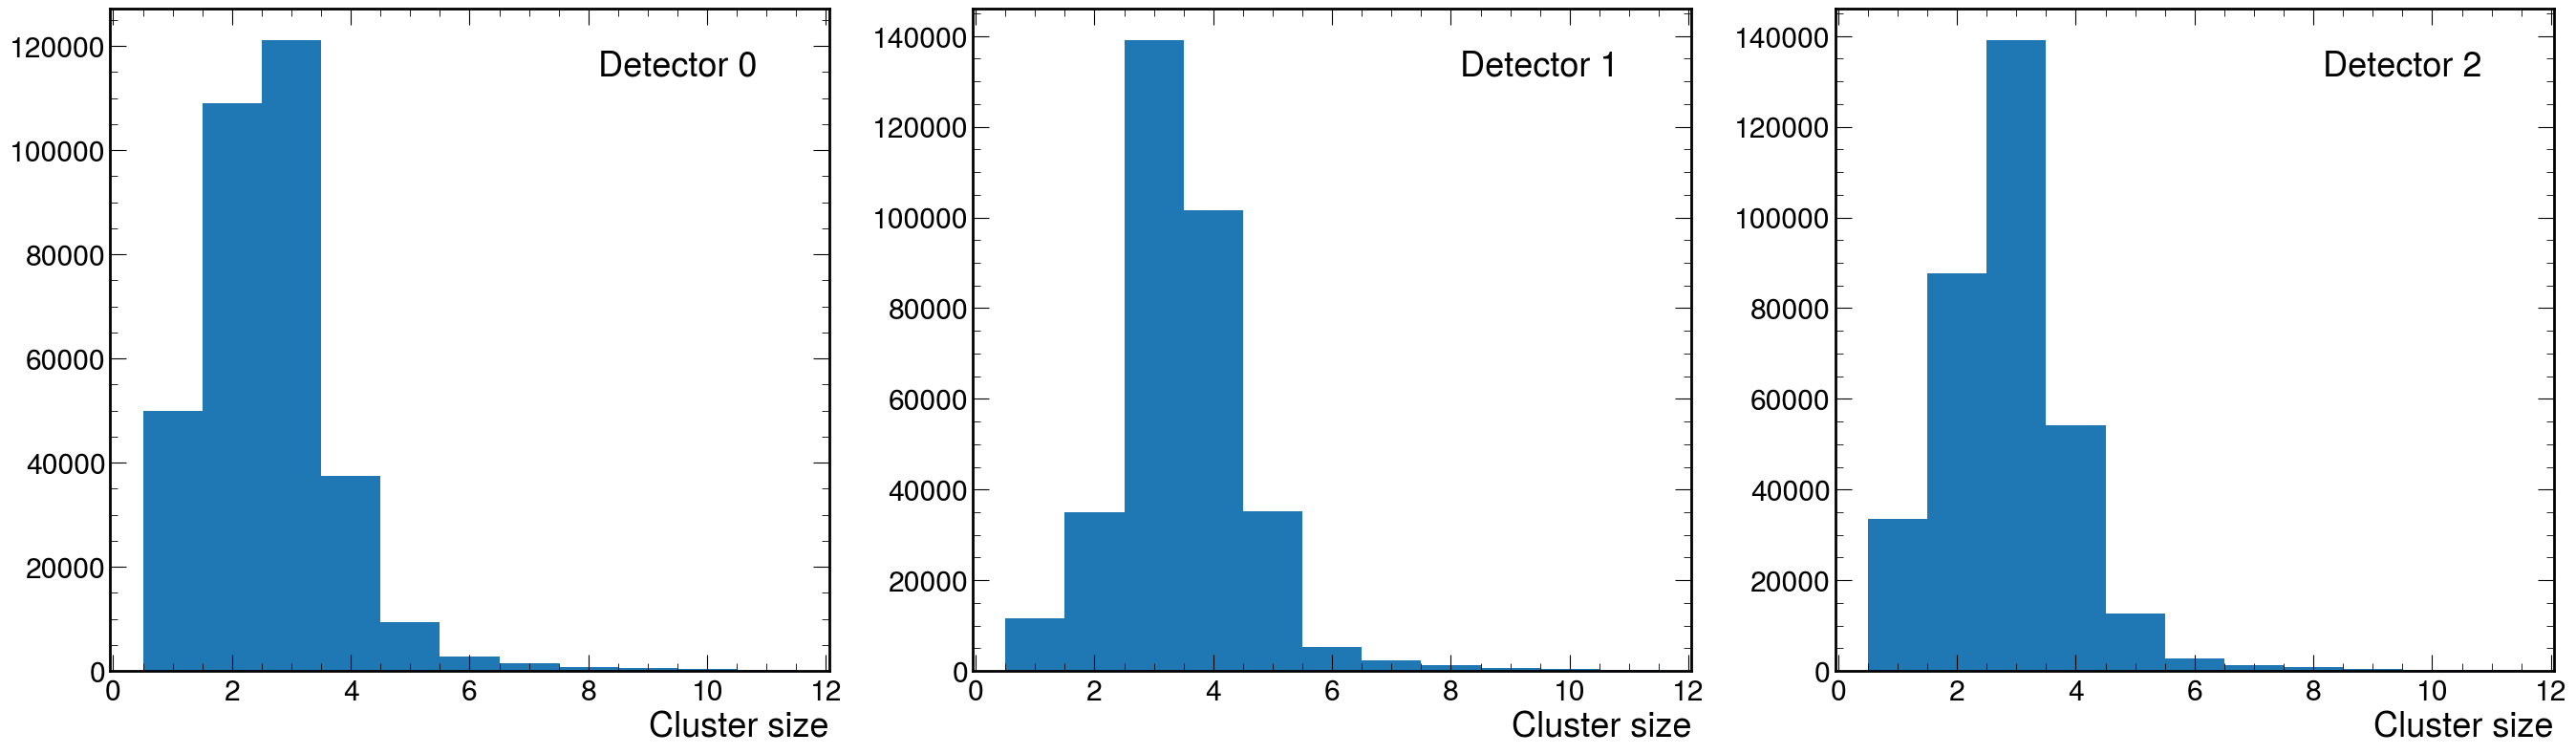

In [147]:
list_chambers = np.unique(ak.flatten(rechits_chamber))
n_chambers = len(list_chambers)

fig, ax = plt.subplots(ncols=n_chambers, nrows=1, figsize=(11*n_chambers,9))
for i,ch in enumerate(list_chambers):
    _ = ax[i].hist(ak.flatten(rechits_cluster_size[rechits_chamber==ch]), bins=11, range=(0.5, 11.5))
    ax[i].set_xlabel("Cluster size")
    ax[i].text(0.9, 0.9, f"Detector {ch}", transform=ax[i].transAxes, ha="right")

In [179]:
tested_chamber = 1

rechits_eta_chamber = rechits_eta[rechits_chamber==tested_chamber]
rechits_cluster_size_chamber = rechits_cluster_size[rechits_chamber==tested_chamber]
rechits_x_chamber = rechits_x[rechits_chamber==tested_chamber]
rechits_y_chamber = rechits_y[rechits_chamber==tested_chamber]
rechits_r_chamber = rechits_r[rechits_chamber==tested_chamber]
rechits_phi_chamber = rechits_phi[rechits_chamber==tested_chamber]
prophits_x_chamber = prophits_x[prophits_chamber==tested_chamber]
prophits_y_chamber = prophits_y[prophits_chamber==tested_chamber]

print("Eta", rechits_eta_chamber)
print("Rechit x", rechits_x_chamber)
print("Rechit y", rechits_y_chamber)
print("Rechit cluster size", rechits_cluster_size_chamber)
print("Prophit x", prophits_x_chamber)
print("Prophit y", prophits_y_chamber)

Eta [[2], [1], [1], [], [1], [2], [3], [1], ..., [2], [], [], [2], [1], [2], [1]]
Rechit x [[-30.7], [90.4], [77.5], [], [-3], ..., [], [55.1], [5], [-82.2], [-76.5]]
Rechit y [[246], [345], [345], [], [345], [246], ..., [], [], [246], [345], [246], [345]]
Rechit cluster size [[2], [4], [4], [], [3], [3], [2], [4], ..., [4], [], [], [3], [3], [4], [4]]
Prophit x [[-30], [90.2], [77.5], [], [-3.75], ..., [], [56.4], [6], [-81.8], [-75.7]]
Prophit y [[246], [345], [345], [], [345], [197], ..., [], [], [246], [345], [246], [345]]


In [180]:
pd.DataFrame({
    "Eta":ak.flatten(rechits_eta_chamber),
    "Rechit x":ak.flatten(rechits_x_chamber),
    "Prophit x":ak.flatten(prophits_x_chamber)
})

Eta    Rechit x   Prophit x
0       2.0  -30.665917  -29.999265
1       1.0   90.446971   90.197121
2       1.0   77.454588   77.454585
3       1.0   -2.998242   -3.747805
4       2.0  127.108006  118.597051
...     ...         ...         ...
333781  2.0   39.554589   39.110158
333782  2.0   55.109765   56.443067
333783  1.0    4.997070    5.996483
333784  2.0  -82.220213  -81.775781
333785  1.0  -76.455174  -75.705622

[333786 rows x 3 columns]

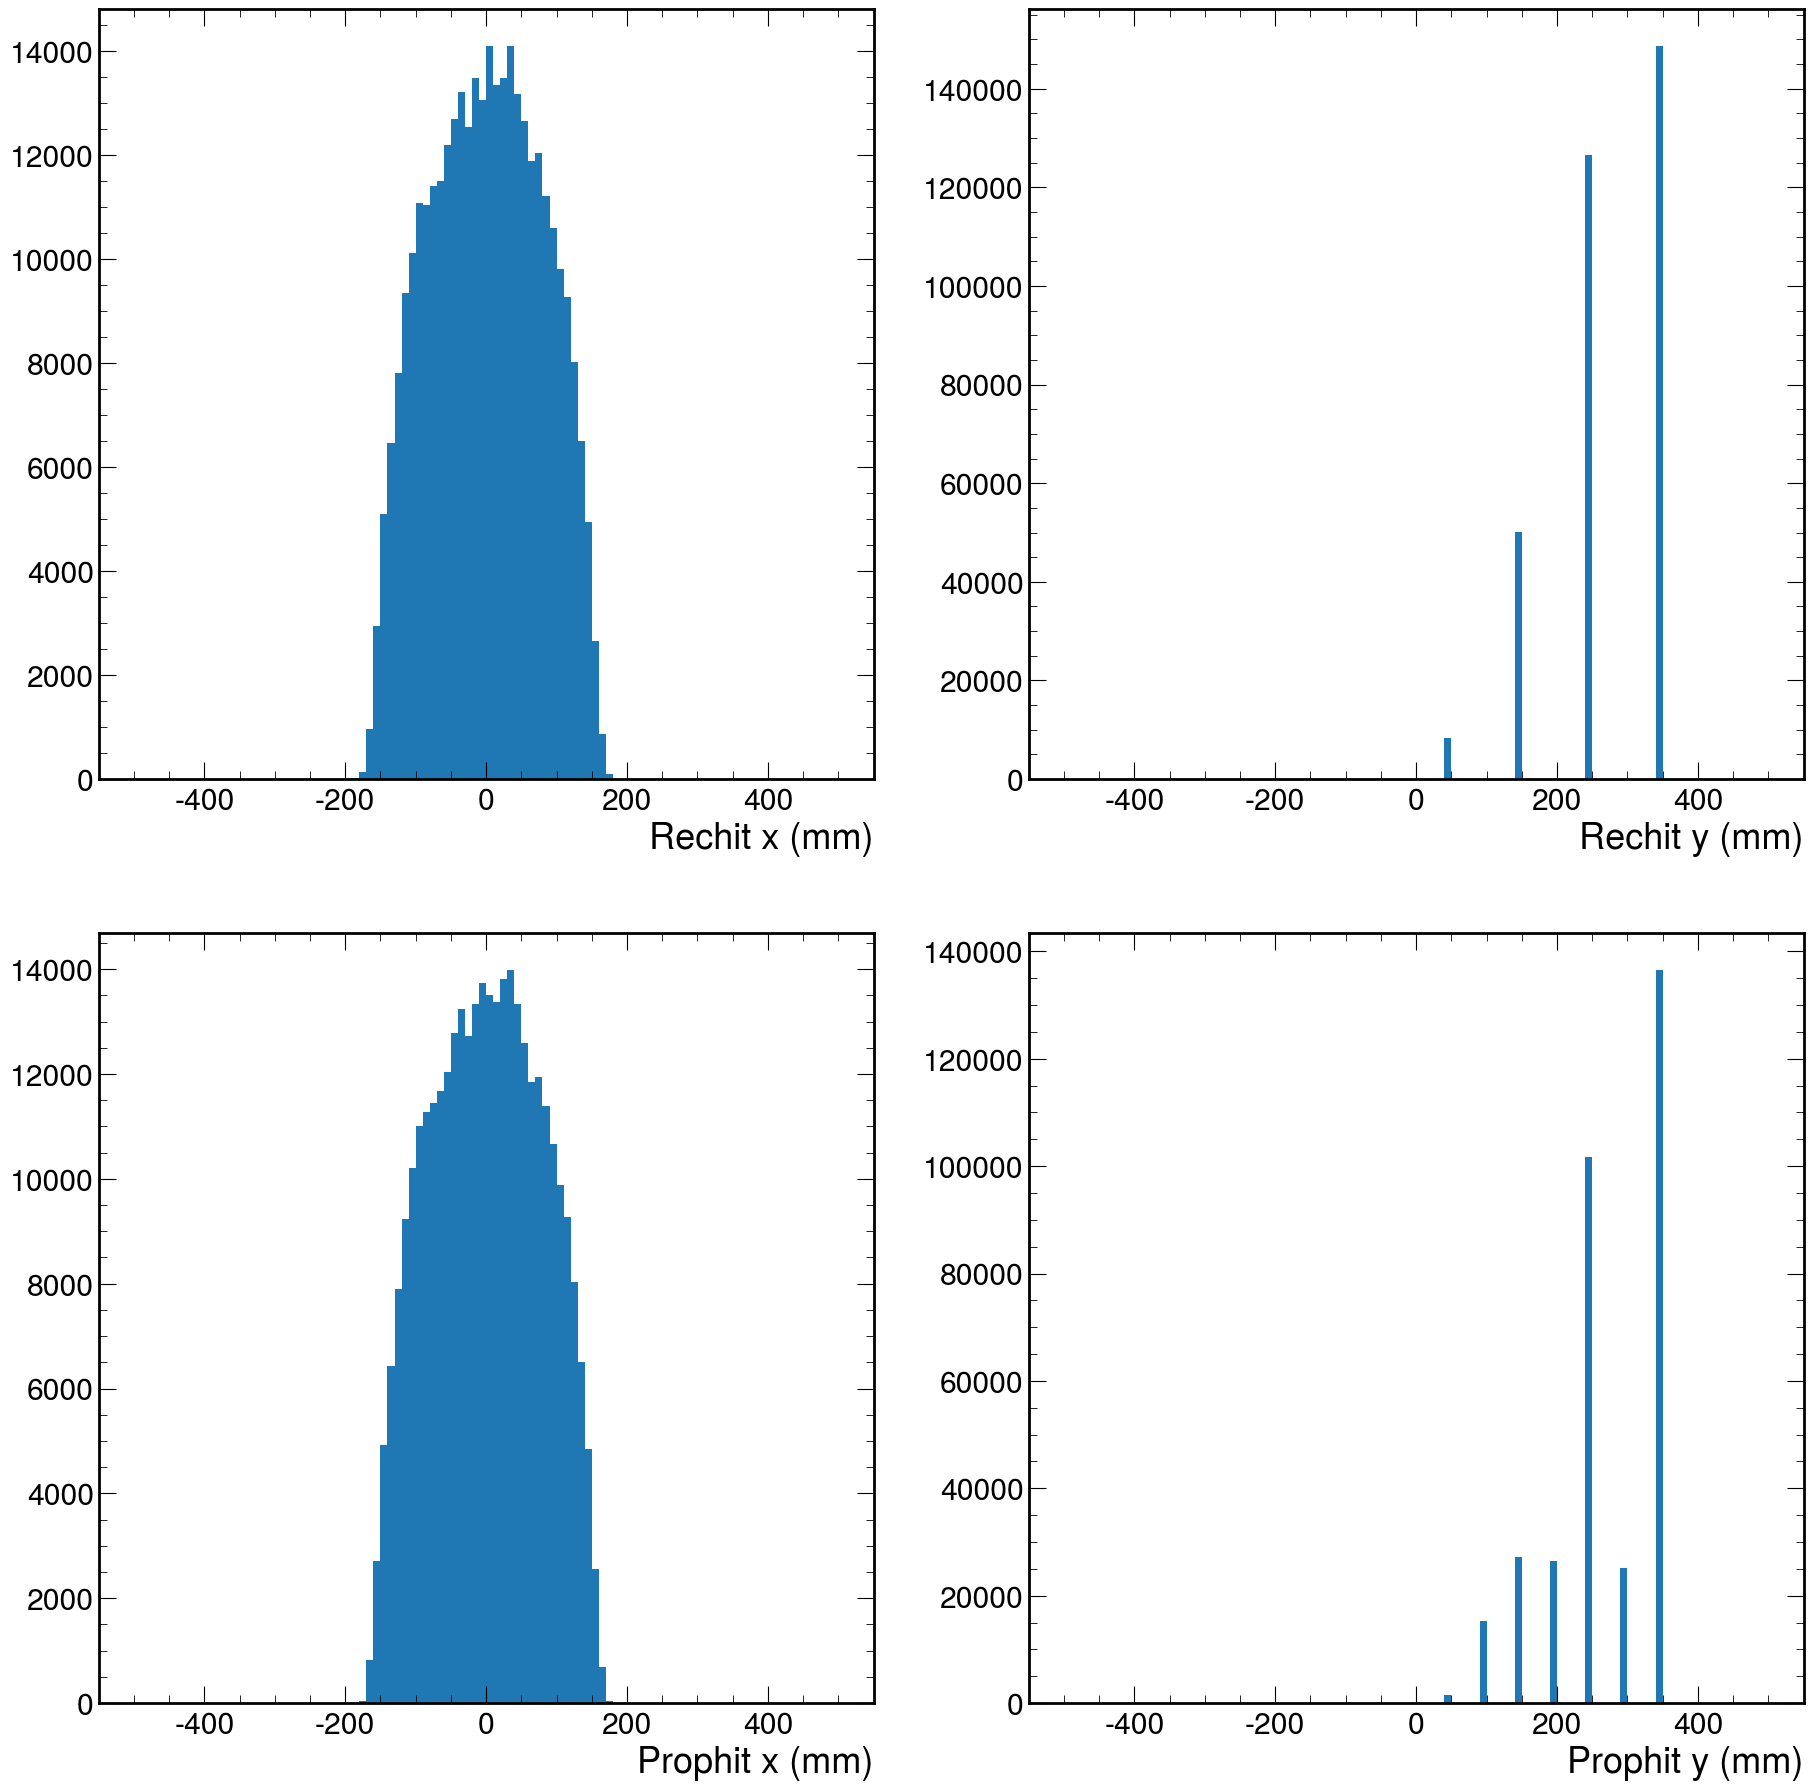

In [303]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
_ = ax[0][0].hist(ak.flatten(rechits_x_chamber), bins=100, range=(-500,500))
_ = ax[0][1].hist(ak.flatten(rechits_y_chamber), bins=100, range=(-500,500))
_ = ax[1][0].hist(ak.flatten(prophits_x_chamber), bins=100, range=(-500,500))
_ = ax[1][1].hist(ak.flatten(prophits_y_chamber), bins=100, range=(-500,500))

_ = ax[0][0].set_xlabel("Rechit x (mm)")
_ = ax[0][1].set_xlabel("Rechit y (mm)")
_ = ax[1][0].set_xlabel("Prophit x (mm)")
_ = ax[1][1].set_xlabel("Prophit y (mm)")

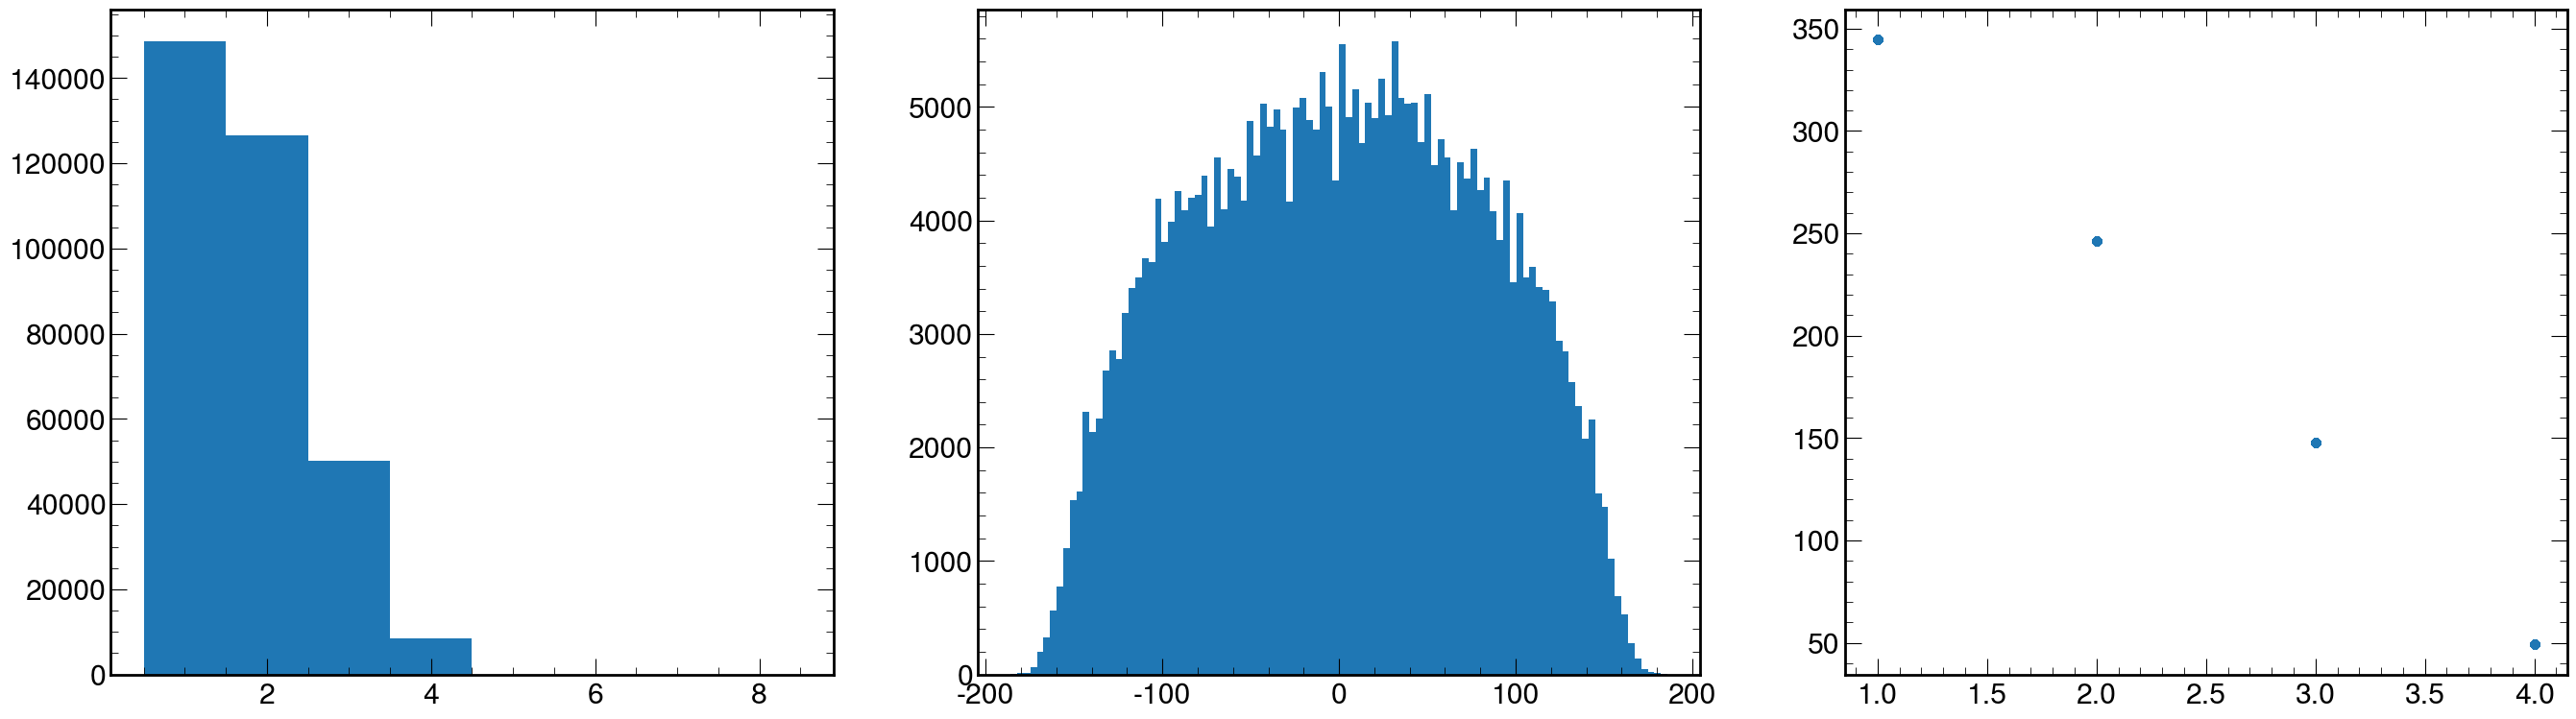

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(33,9))
_ = ax[0].hist(ak.flatten(rechits_eta_chamber), bins=8, range=(0.5, 8.5))
_ = ax[1].hist(ak.flatten(rechits_x_chamber), bins=100)
_ = ax[2].scatter(
    ak.flatten(rechits_eta_chamber), ak.flatten(rechits_y_chamber),
)

[-30.7, 90.4, 77.5, -3, 127, 117, 42.5, ..., 12, 39.6, 55.1, 5, -82.2, -76.5] 333786
[246, 345, 345, 345, 246, 148, 345, 345, ..., 246, 246, 246, 246, 345, 246, 345] 333786


Text(0, 1, 'Prophits y (mm)')

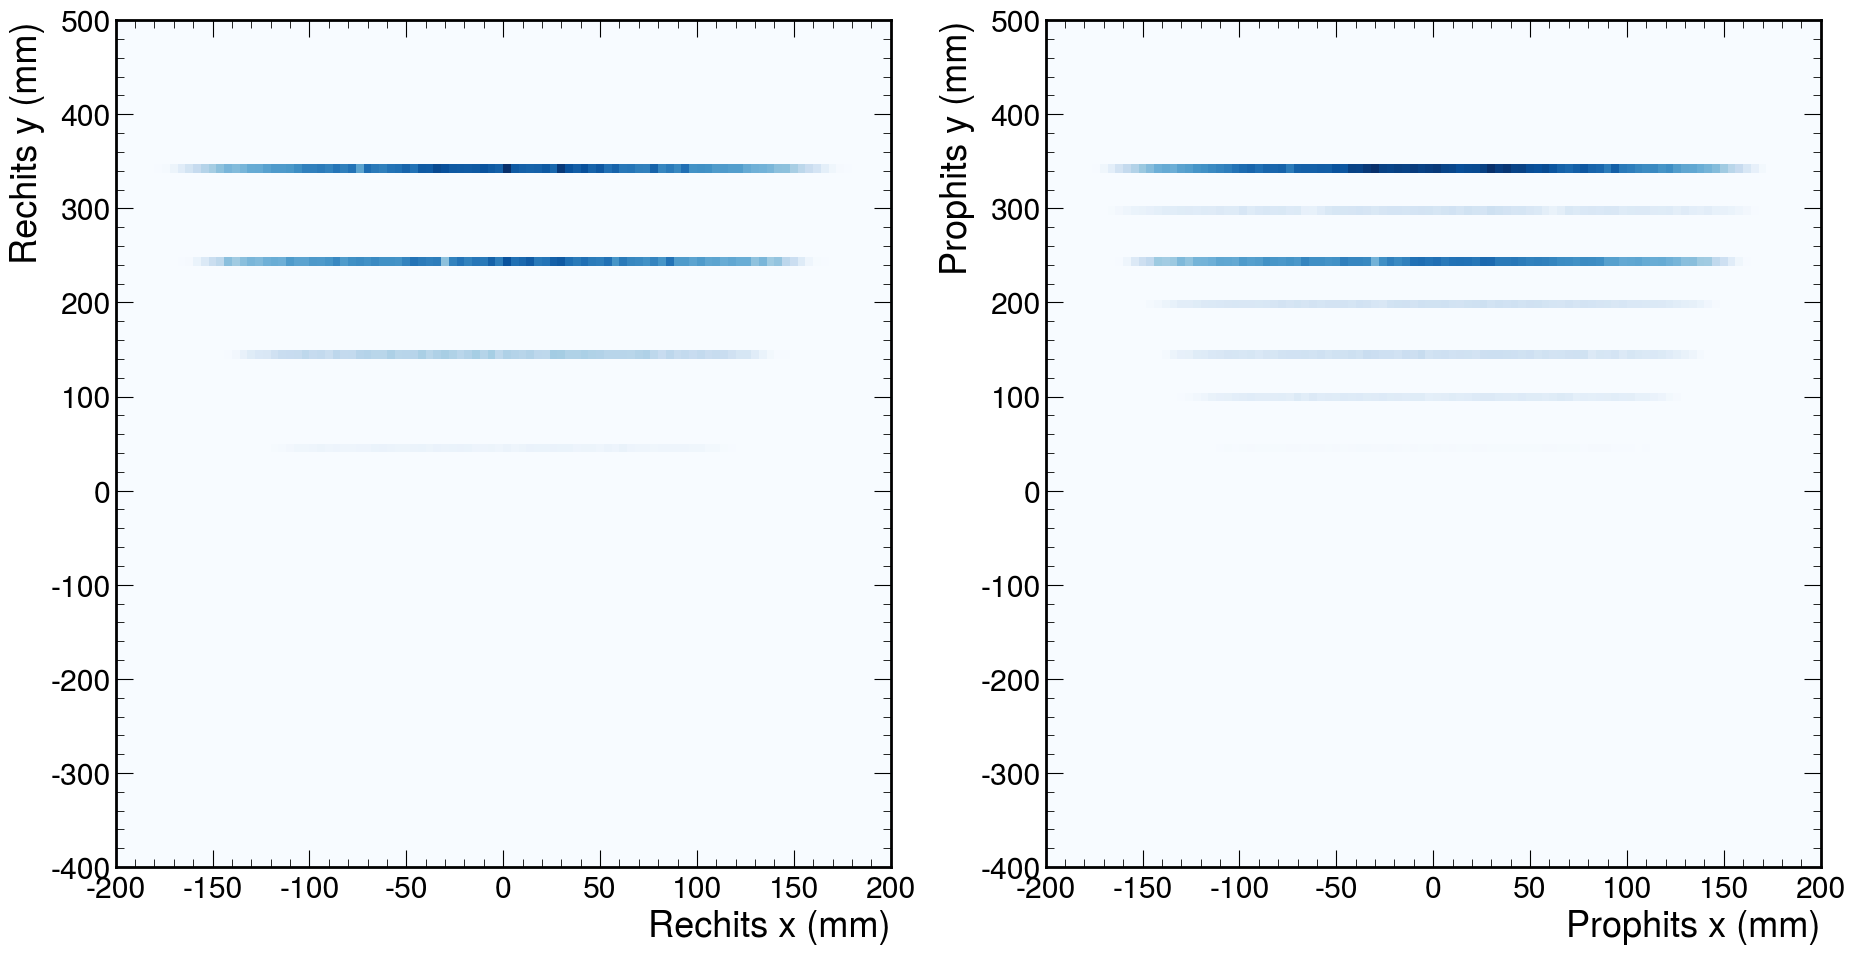

In [183]:
print(ak.flatten(rechits_x_chamber), ak.count(ak.flatten(rechits_x_chamber)))
print(ak.flatten(rechits_y_chamber), ak.count(ak.flatten(rechits_y_chamber)))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,11))
_ = ax[0].hist2d(
    ak.flatten(rechits_x_chamber).to_numpy(), ak.flatten(rechits_y_chamber).to_numpy(),
    bins=(100,100), range=((-200,200),(-400,500)), cmap="Blues"
)
_ = ax[1].hist2d(
    ak.flatten(prophits_x_chamber).to_numpy(), ak.flatten(prophits_y_chamber).to_numpy(),
    bins=(100,100), range=((-200,200),(-400,500)), cmap="Blues"
)
ax[0].set_xlabel("Rechits x (mm)")
ax[0].set_ylabel("Rechits y (mm)")
ax[1].set_xlabel("Prophits x (mm)")
ax[1].set_ylabel("Prophits y (mm)")

In [184]:
# choose only events with both a prophit and a rechit and broadcast the prophits
residual_filter = (ak.count(rechits_x_chamber, axis=1)>0)&(ak.count(prophits_x_chamber, axis=1)>0)

rechits_x_broadcast, prophits_x_broadcast = ak.broadcast_arrays(
    rechits_x_chamber[residual_filter],
    ak.flatten(prophits_x_chamber[residual_filter])
)
print("Rechits x:", rechits_x_broadcast)
print("Prophits x:", prophits_x_broadcast)

residual_filter = (ak.count(rechits_y_chamber, axis=1)>0)&(ak.count(prophits_y_chamber, axis=1)>0)
rechits_y_broadcast, prophits_y_broadcast = ak.broadcast_arrays(
    rechits_y_chamber[residual_filter],
    ak.flatten(prophits_y_chamber[residual_filter])
)
print("Rechits y:", rechits_y_broadcast)
print("Prophits y:", prophits_y_broadcast)

position_filter = abs(prophits_x_broadcast)>10
residuals_y = rechits_y_broadcast-prophits_y_broadcast
residuals_x = rechits_x_broadcast-prophits_x_broadcast

Rechits x: [[-30.7], [90.4], [77.5], [-3], [127], ..., [55.1], [5], [-82.2], [-76.5]]
Prophits x: [[-30], [90.2], [77.5], [-3.75], [119], ..., [56.4], [6], [-81.8], [-75.7]]
Rechits y: [[246], [345], [345], [345], [246], ..., [246], [246], [345], [246], [345]]
Prophits y: [[246], [345], [345], [345], [197], ..., [246], [246], [345], [246], [345]]


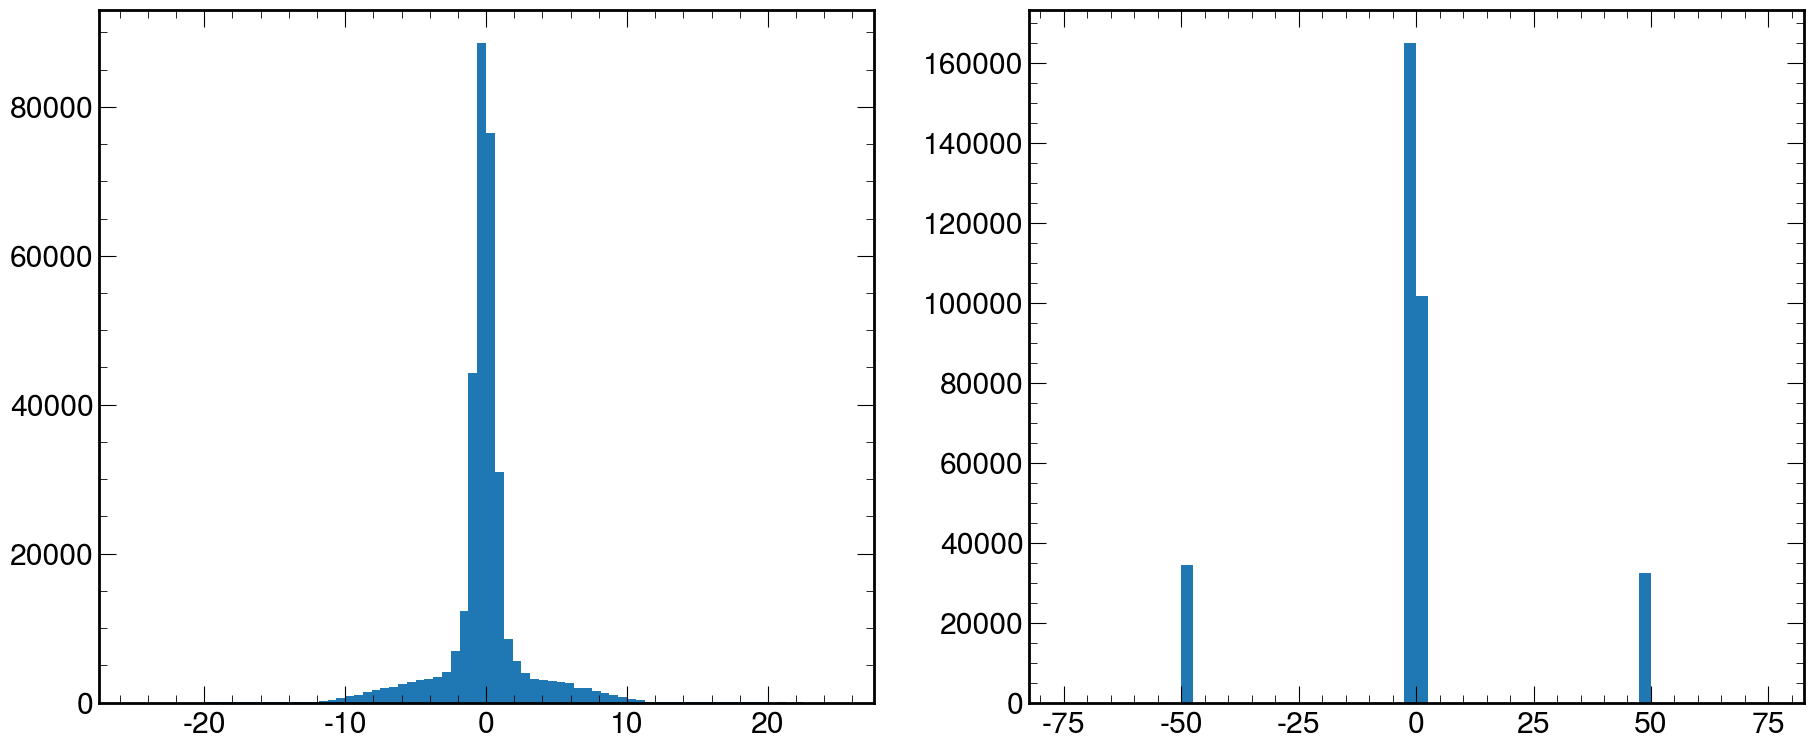

In [187]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,9))
_ = ax[0].hist(ak.min(residuals_x, axis=1), bins=80, range=(-25,25))
_ = ax[1].hist(ak.min(residuals_y, axis=1), bins=60, range=(-75,75))

[-0.10027749325543155, 55823.0, 3.650239571812737, -0.10027749325543155, 5582.3, 36.502395718127374]
Correction x -0.10254359019288925 ± 0.009660712268672239 mm
Resolution x 0.6290362839466499 ± 0.011143647828932365 mm
Opt: [-1.02543590e-01  8.82450777e+04  6.29036284e-01 -1.14467040e-01
  3.94478171e+04  4.76440490e+00]
Err: [9.66071227e-03 1.71904555e+03 1.11436478e-02 4.50468839e-01
 3.45023937e+03 5.19612673e-01]


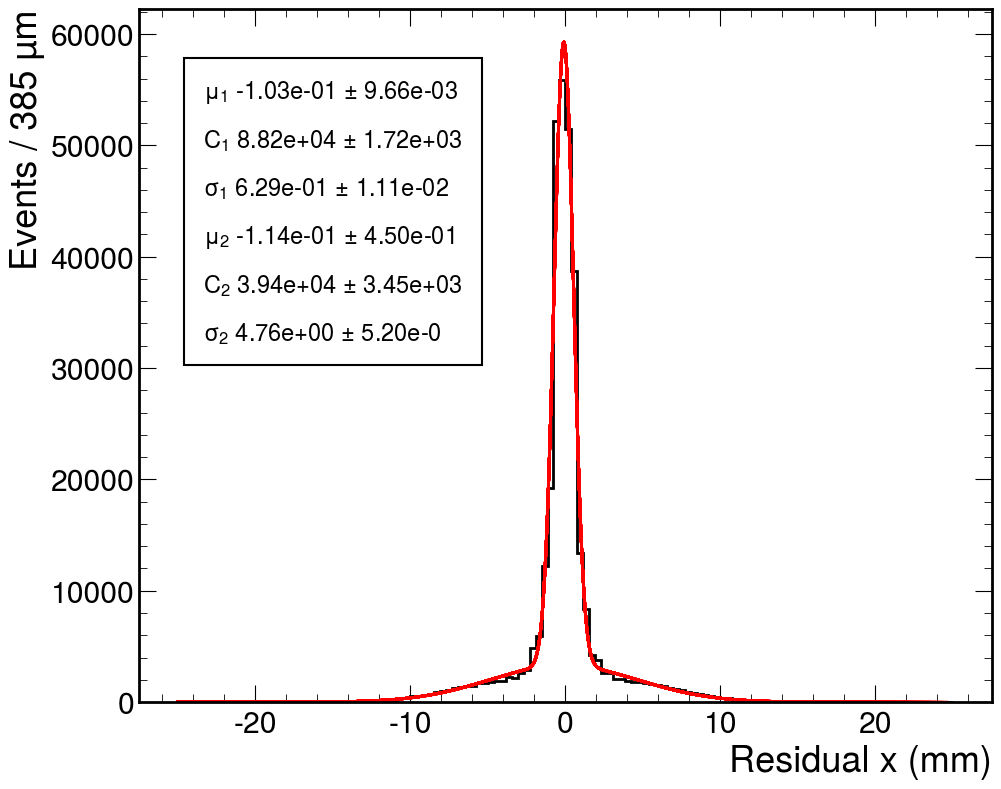

In [250]:
residuals_x_flat = ak.min(residuals_x, axis=1).to_numpy()
residuals_x_flat = ak.flatten(residuals_x).to_numpy()

fig, ax = plt.subplots(figsize=(11,9))
counts, x_edges, _ = ax.hist(
    residuals_x_flat,
    histtype="step", linewidth=2, color="k",
    bins=130, range=(-25,25)
)

# Fig with two gaussians:
x_centers = 0.5*(x_edges[1:]+x_edges[:-1])
popt = [ residuals_x_flat.mean(), counts.max(), residuals_x_flat.std() ]
popt += [ residuals_x_flat.mean(), 0.1*counts.max(), 10*residuals_x_flat.std() ]
print(popt)
popt, pcov = curve_fit(gauss2_pdf, x_centers, counts)
perr = np.sqrt(np.diag(pcov))

x_correction, x_resolution = popt[0], popt[2]
err_x_correction, err_x_resolution = perr[0], perr[2]
print("Correction x", x_correction, "±", err_x_correction, "mm")
print("Resolution x", x_resolution, "±", err_x_resolution, "mm")
print("Opt:", popt)
print("Err:", perr)

x = np.linspace(x_edges[0], x_edges[:-1], 1000)
_ = ax.plot(x, gauss2_pdf(x, *popt), linewidth=2, color="red")

binning = np.diff(x_edges).mean()
ax.set_xlabel("Residual x (mm)")
ax.set_ylabel(f"Events / {binning*1e3:1.0f} µm")

pname = ["$\mu_1$", "$C_1$", "$\sigma_1$", "$\mu_2$", "$C_2$", "$\sigma_2$"]
fit_text = ""
for i,(p,e,n) in enumerate(zip(popt, perr, pname)):
    fit_text += f"{n: >5} {p:1.2e} $\pm$ {e:1.2e}\n"
fit_text = fit_text[:-2]
_ = ax.text(
    0.075, 0.9, fit_text,
    transform = ax.transAxes, ha="left", va="top",
    fontsize=17, linespacing=2.1,
    bbox=dict(boxstyle="square, pad=0.8", facecolor="white", linewidth=1.5)
)

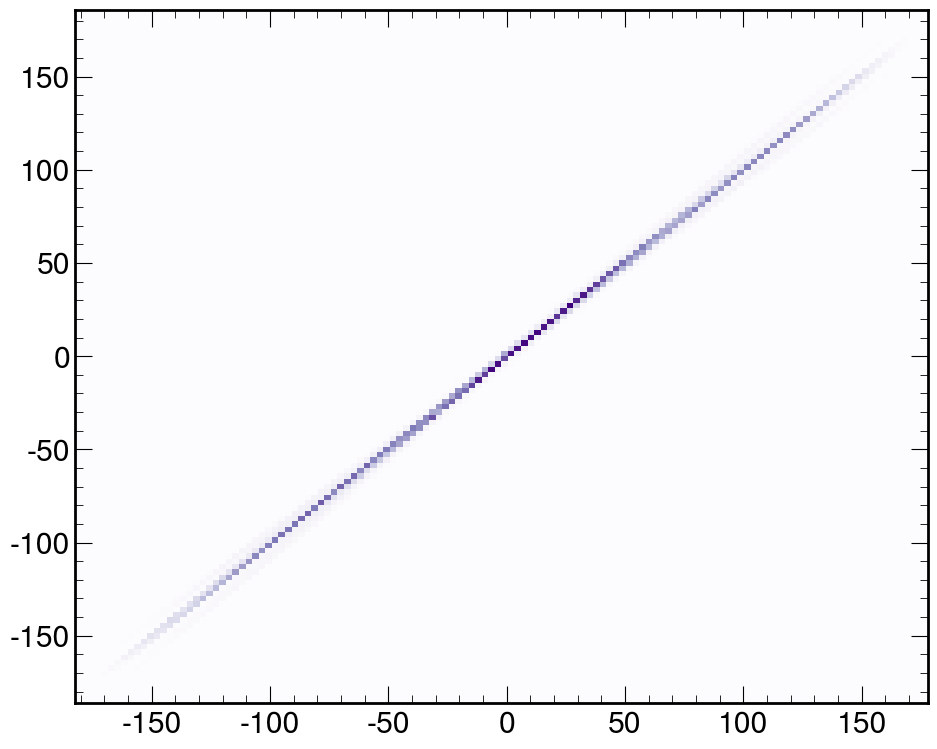

In [252]:
fig, ax = plt.subplots(figsize=(11,9))
_ = ax.hist2d(
    ak.flatten(prophits_x_broadcast).to_numpy(), ak.flatten(rechits_x_broadcast).to_numpy(),
    bins=130, #range=(-200,200)
)

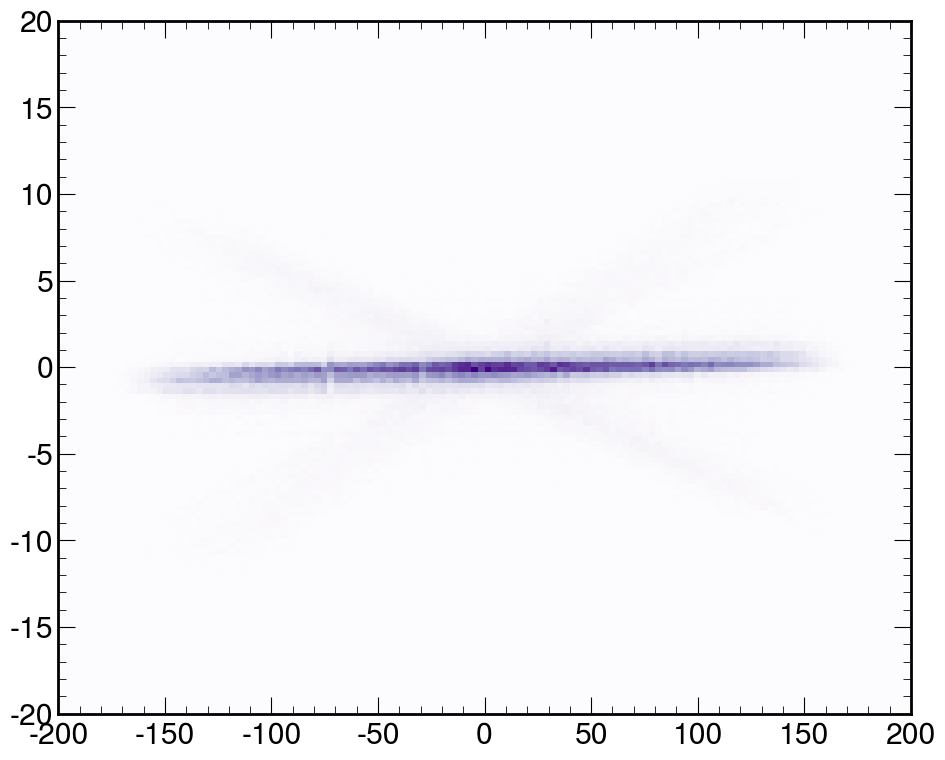

In [254]:
fig, ax = plt.subplots(figsize=(11,9))
_ = ax.hist2d(
    ak.flatten(prophits_x_broadcast).to_numpy(), ak.flatten(residuals_x).to_numpy(),
    bins=130, range=((-200,200),(-20,20))
)

[[-0.667], [0.25], [3.58e-06], [0.75], ..., [-0.999], [-0.444], [-0.75]]
[True, True, True, True, True, True, ..., True, True, True, True, True, True]


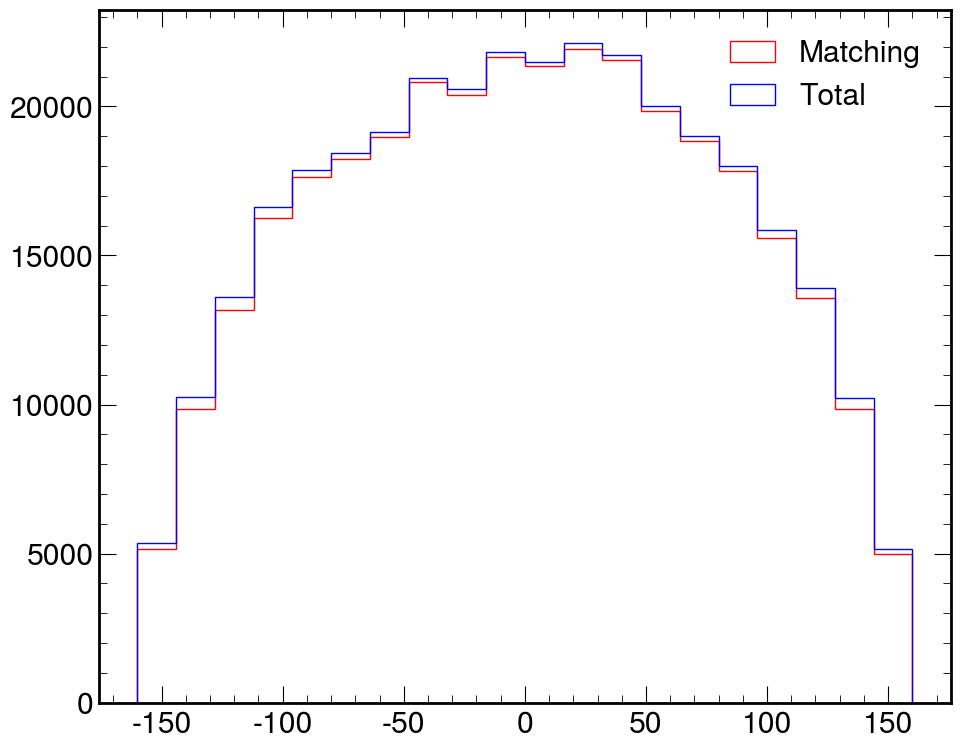

In [300]:
matching_cut = 10
prophit_region = (-160, 160)
efficiency_bins = 20

event_has_match = ak.count_nonzero(abs(residuals_x)<matching_cut, axis=1)>0
print(residuals_x)
print(event_has_match)

prophits_matching = prophits_x_broadcast[event_has_match]
prophits_total = prophits_x_broadcast

fig, ax = plt.subplots(figsize=(11,9))
matching_counts, matching_edges, _ = ax.hist(
    ak.flatten(prophits_matching),
    bins=efficiency_bins, range=prophit_region,
    histtype="step", label="Matching", color="red"
)
total_counts, total_edges, _ = ax.hist(
    ak.flatten(prophits_total),
    bins=efficiency_bins, range=prophit_region,
    histtype="step", label="Total", color="blue"
)
ax.legend()

Text(0, 1, 'Efficiency')

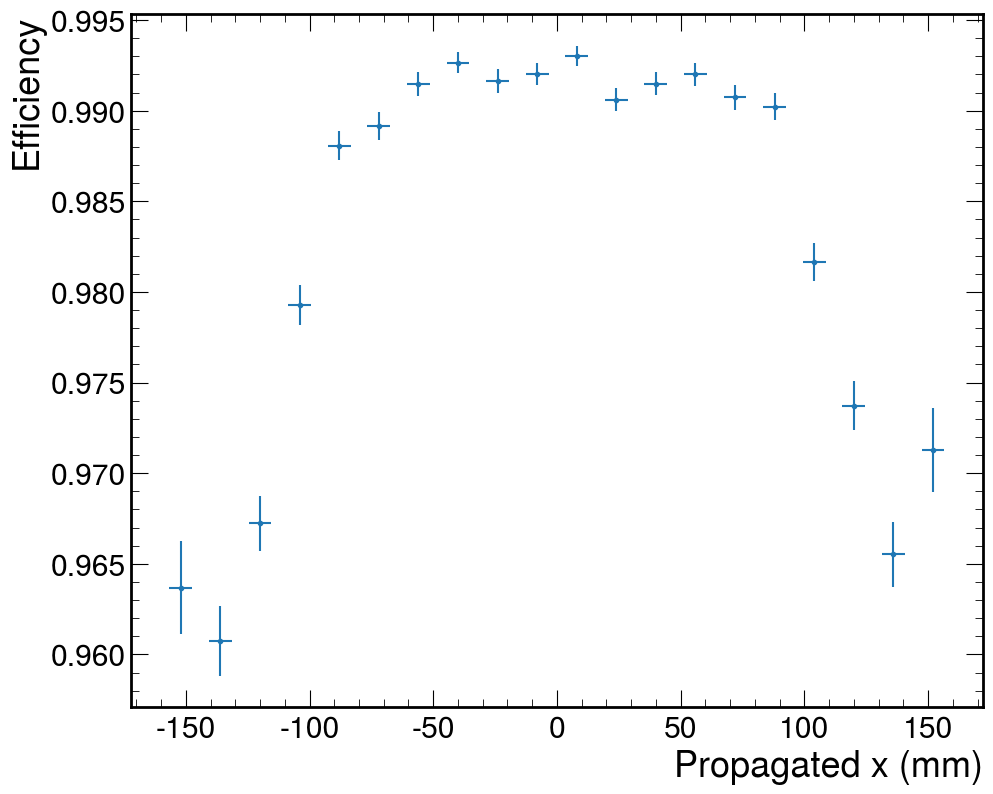

In [301]:
efficiency = matching_counts / total_counts
x_centers = 0.5*(matching_edges[1:]+matching_edges[:-1])
x_errors = np.diff(matching_edges)/np.sqrt(12)
efficiency_errors = np.sqrt(efficiency*(1-efficiency)/total_counts)

fig, ax = plt.subplots(figsize=(11,9))
ax.errorbar(x_centers, efficiency, xerr=x_errors, yerr=efficiency_errors, fmt=".")

ax.set_xlabel("Propagated x (mm)")
ax.set_ylabel("Efficiency")